In [1]:
import numpy as np
import tables
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import os
import pickle
import json
from utils import *

Initializing Parameters...


In [2]:
f_dir = "gamma_inout_reinit_model"
rep = 0
lr = 0.02

In [70]:

with open(os.path.join(f_dir, "init_weight_%d_lr%f.pth" % (rep, lr)), "rb") as f:
        all_weights = np.load(f, allow_pickle=True)
all_weights = all_weights.item()
w_out = all_weights['w_out0']
out_mask = all_weights['out_mask_init']
w_in = all_weights['w_in0']
in_mask = all_weights['in_mask_init']
w_rnn = all_weights['w_rnn0']
rnn_mask = all_weights['rnn_mask_init']

out_conn_c0 = out_mask[:, 0].astype(bool)
out_conn_c1 = out_mask[:, 1].astype(bool)
rnn_conn_c0 = np.sum(rnn_mask[:, out_conn_c0], axis=1).astype(bool)
rnn_conn_c1 = np.sum(rnn_mask[:, out_conn_c1], axis=1).astype(bool)
in_conn_c0 = np.sum(in_mask[:, rnn_conn_c0], axis=1).astype(bool)
in_conn_c1 = np.sum(in_mask[:, rnn_conn_c1], axis=1).astype(bool)

np.sum(in_mask[:, out_conn_c0]), np.sum(in_mask[:, out_conn_c1])


(30.0, 29.0)

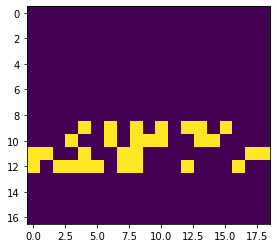

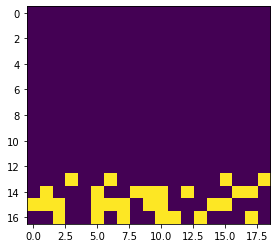

In [68]:
plt.figure()
plt.imshow(in_mask[:, out_conn_c0])
plt.figure()
plt.imshow(in_mask[:, out_conn_c1])


In [ ]:
from plot_out_act import plot_output_sac_selectivity
rep = 4
train_output = tables.open_file(
    os.path.join(f_dir, "train_output_lr%f_rep%d.h5" % (lr, rep)), mode="r"
)
train_table = train_output.root

all_iters = []
for row in train_table:
    iter_num = int(row.name.split("iter")[1])
    if iter_num not in all_iters:
        all_iters.append(iter_num)
    else:
        break


for iter_num in all_iters:
    y_iter0 = train_table['y_hist_iter%d'%iter_num][:]
    desired_out_iter0 = train_table["target_iter%d"%iter_num][:]
    stim_level_iter0 = train_table["stim_level_iter%d"%iter_num][:]
    stim_dir_iter0 = train_table["stim_dir_iter%d"%iter_num][:]
    desired_out_iter0, stim_dir_iter0 = correct_zero_coh(y_iter0, stim_level_iter0, stim_dir_iter0, desired_out_iter0)
    plot_output_sac_selectivity(y_iter0, desired_out_iter0, stim_level_iter0, 'Ouput_saccade_selectivity_iter%d'%(iter_num), False)

In [40]:
rep = 1
train_output = tables.open_file(
    os.path.join(f_dir, "train_output_lr%f_rep%d.h5" % (lr, rep)), mode="r"
)
train_table = train_output.root

all_iters = []
for row in train_table:
    iter_num = int(row.name.split("iter")[1])
    if iter_num not in all_iters:
        all_iters.append(iter_num)
    else:
        break

all_w_rnn = {}
for iter_num in all_iters:
    all_w_rnn[iter_num] = train_table['w_rnn_iter%d'%iter_num][:]


In [71]:
for rep in range(5):
    test_output = tables.open_file(
        os.path.join(f_dir, "test_output_lr%f_rep%d.h5" % (lr, rep)), mode="r"
    )
    test_table = test_output.root
    y_test = test_table['y_hist_iter0'][:]
    target_test = test_table['target_iter0'][:]
    correct_idx_test = find_correct_idx(y_test, target_test)
    c0_wrong_num = sum(~correct_idx_test[target_test[-1, :, 0].astype(bool)])
    c1_wrong_num = sum(~correct_idx_test[target_test[-1, :, 1].astype(bool)])
    print('rep %d: '%rep)
    print('# left choice wrong = %d, # right_choice wrong = %d'%(c0_wrong_num, c1_wrong_num))

rep 0: 
# left choice wrong = 254, # right_choice wrong = 317
rep 1: 
# left choice wrong = 279, # right_choice wrong = 389
rep 2: 
# left choice wrong = 342, # right_choice wrong = 379
rep 3: 
# left choice wrong = 294, # right_choice wrong = 243
rep 4: 
# left choice wrong = 268, # right_choice wrong = 263


Text(0.5, 1.0, 'RNN neurons output to left choice average activity (sep by stimulus direction)')

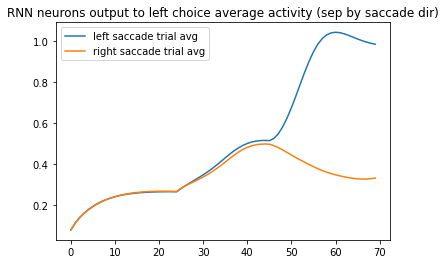

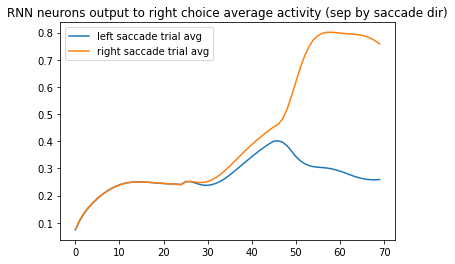

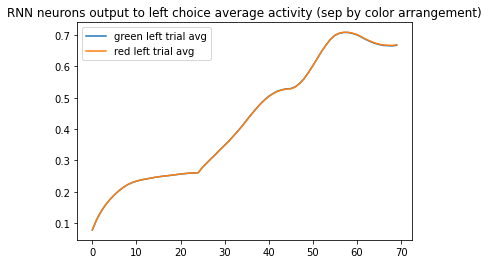

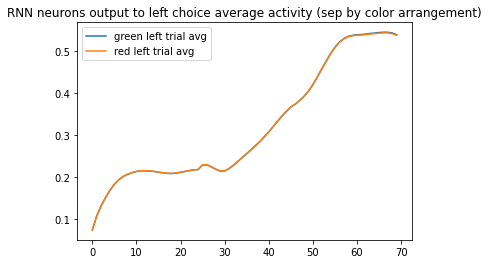

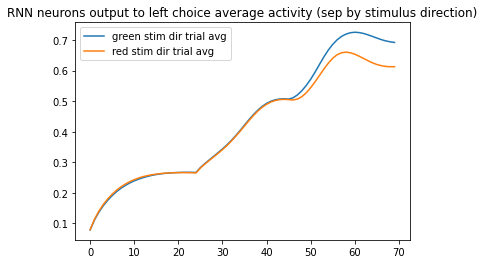

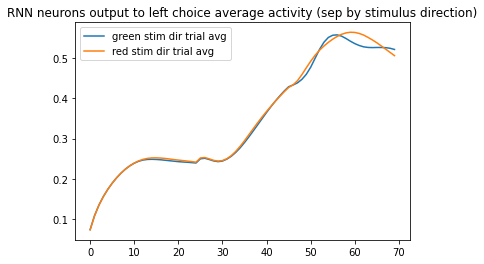

In [123]:
rep = 4

test_output = tables.open_file(
    os.path.join(f_dir, "test_output_lr%f_rep%d.h5" % (lr, rep)), mode="r"
)
test_table = test_output.root
y_test = test_table['y_hist_iter0'][:]
target_test = test_table['target_iter0'][:]
h_test = test_table['h_iter0'][:]
stim_dir_test = test_table['stim_dir_iter0'][:]
choice = np.argmax(y_test[-1, :, :], axis=1).astype(bool)


with open(os.path.join(f_dir, "init_weight_%d_lr%f.pth" % (rep, lr)), "rb") as f:
        all_weights = np.load(f, allow_pickle=True)
all_weights = all_weights.item()
w_out = all_weights['w_out0']
out_mask = all_weights['out_mask_init']
w_in = all_weights['w_in0']
in_mask = all_weights['in_mask_init']
w_rnn = all_weights['w_rnn0']
rnn_mask = all_weights['rnn_mask_init']

out_conn_c0 = out_mask[:, 0].astype(bool)
out_conn_c1 = out_mask[:, 1].astype(bool)


plt.figure()
plt.plot(np.mean(h_test[:, np.where(~choice)[0], :][:, :, np.where(out_conn_c0)[0]], axis=(1, 2)), label='left saccade trial avg')
plt.plot(np.mean(h_test[:, np.where(choice)[0], :][:, :, np.where(out_conn_c0)[0]], axis=(1, 2)), label='right saccade trial avg')
plt.legend()
plt.title('RNN neurons output to left choice average activity (sep by saccade dir)')

plt.figure()
plt.plot(np.mean(h_test[:, np.where(~choice)[0], :][:, :, np.where(out_conn_c1)[0]], axis=(1, 2)), label='left saccade trial avg')
plt.plot(np.mean(h_test[:, np.where(choice)[0], :][:, :, np.where(out_conn_c1)[0]], axis=(1, 2)), label='right saccade trial avg')
plt.legend()
plt.title('RNN neurons output to right choice average activity (sep by saccade dir)')

# color_loc = recover_targ_loc(target_test, stim_dir_test)
# plt.figure()
# plt.plot(np.mean(h_test[:, np.where(~color_loc)[0], :][:, :, np.where(out_conn_c0)[0]], axis=(1, 2)), label='green left trial avg')
# plt.plot(np.mean(h_test[:, np.where(color_loc)[0], :][:, :, np.where(out_conn_c0)[0]], axis=(1, 2)), label='red left trial avg')
# plt.legend()
# plt.title('RNN neurons output to left choice average activity (sep by color arrangement)')

# plt.figure()
# plt.plot(np.mean(h_test[:, np.where(~color_loc)[0], :][:, :, np.where(out_conn_c1)[0]], axis=(1, 2)), label='green left trial avg')
# plt.plot(np.mean(h_test[:, np.where(color_loc)[0], :][:, :, np.where(out_conn_c1)[0]], axis=(1, 2)), label='red left trial avg')
# plt.legend()
# plt.title('RNN neurons output to left choice average activity (sep by color arrangement)')

# plt.figure()
# plt.plot(np.mean(h_test[:, np.where(stim_dir_test==135)[0], :][:, :, np.where(out_conn_c0)[0]], axis=(1, 2)), label='green stim dir trial avg')
# plt.plot(np.mean(h_test[:, np.where(stim_dir_test==315)[0], :][:, :, np.where(out_conn_c0)[0]], axis=(1, 2)), label='red stim dir trial avg')
# plt.legend()
# plt.title('RNN neurons output to left choice average activity (sep by stimulus direction)')

# plt.figure()
# plt.plot(np.mean(h_test[:, np.where(stim_dir_test==135)[0], :][:, :, np.where(out_conn_c1)[0]], axis=(1, 2)), label='green stim dir trial avg')
# plt.plot(np.mean(h_test[:, np.where(stim_dir_test==315)[0], :][:, :, np.where(out_conn_c1)[0]], axis=(1, 2)), label='red stim dir trial avg')
# plt.legend()
# plt.title('RNN neurons output to left choice average activity (sep by stimulus direction)')

Text(0.5, 1.0, 'RNN neurons output to left choice average activity ')

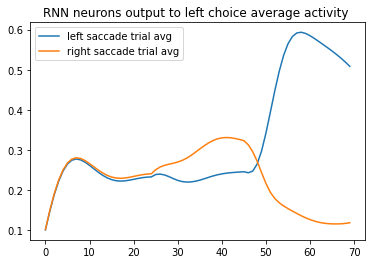

In [113]:

plt.figure()
plt.plot(np.mean(h_test[:, np.where(~choice)[0], :][:, :, np.where(out_conn_c0)[0]], axis=(1, 2)), label='left saccade trial avg')
plt.plot(np.mean(h_test[:, np.where(choice)[0], :][:, :, np.where(out_conn_c0)[0]], axis=(1, 2)), label='right saccade trial avg')
plt.legend()
plt.title('RNN neurons output to left choice average activity ')

Text(0.5, 1.0, 'RNN neurons output to right choice average activity ')

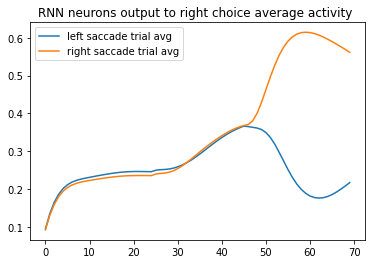

In [114]:
plt.figure()
plt.plot(np.mean(h_test[:, np.where(~choice)[0], :][:, :, np.where(out_conn_c1)[0]], axis=(1, 2)), label='left saccade trial avg')
plt.plot(np.mean(h_test[:, np.where(choice)[0], :][:, :, np.where(out_conn_c1)[0]], axis=(1, 2)), label='right saccade trial avg')
plt.legend()
plt.title('RNN neurons output to right choice average activity ')

In [115]:
np.intersect1d(np.where(out_conn_c0)[0], np.where(out_conn_c1)[0])

array([], dtype=int64)

In [ ]:
for c0_idx in np.where(out_conn_c0)[0]:
    plt.figure()
    plt.plot(np.mean(h_test[:, ~choice, c0_idx]*w_out[c0_idx, 0], axis=1), label='left avg')
    plt.plot(np.mean(h_test[:, choice, c0_idx]*w_out[c0_idx, 0], axis=1), label='right avg')
    plt.legend()
    plt.title('Cell %d' %c0_idx)

In [ ]:
for c1_idx in np.where(out_conn_c1)[0]:
    plt.figure()
    plt.plot(np.mean(h_test[:, ~choice, c1_idx]*w_out[c1_idx, 1], axis=1), label='left avg')
    plt.plot(np.mean(h_test[:, choice, c1_idx]*w_out[c1_idx, 1], axis=1), label='right avg')
    plt.legend()
    plt.title('Cell %d' %c1_idx)

In [86]:
choice[-20:]

array([0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0],
      dtype=int64)

In [88]:
(1-choice)[-20:]

array([1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1],
      dtype=int64)

In [120]:
test_table

/ (RootGroup) 'Test output'
  children := ['h_iter0' (Array), 'neural_in_iter0' (Array), 'rt_iter0' (Array), 'stim_dir_iter0' (Array), 'stim_level_iter0' (Array), 'target_iter0' (Array), 'y_hist_iter0' (Array)]